

# Project: Investigate relationship between players physical characteristics and  speed using Soccer Database

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> The focus of this project is to investigate the relationship between player physical attributes, preferred foot, age (18-35) and speed, using data from Soccer Database. 
As it was suggested in the Data Set Options Set, the original database was accessed using DB Browser, but the SQL queries will be shown here to give better understanding to the reader. The original database consist of 7 table storing data related to football matches, teams, leagues and players for the period from 2008 to 2016. Considering that this project is focused on players speed and its relationship with other attributes, only two tables will be relevant for this research - "Player" and "Player_Attributes".

- The first question this research will address is: how does speed changes with age for players between 18-35. Is there a correlation between these 2 attributes? 
- Do the same patterns of speed evolution with age hold for different weight and height categories?
- Could weight be a good predictor of expected speed?
- Is there a particular height which associated with slower/faster players?
- Is there significant speed difference depending on preferred foot?

In [1]:
# Use this cell to set up import statements for all of the packages that you
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
%matplotlib inline
import seaborn as sns
import sqlite3

<a id='wrangling'></a>
## Data Wrangling

As it was suggested in the Data Set Options Set, the original database was accessed using DB Browser, but the SQL queries will be shown here to give better understanding to the reader. The original database consist of 7 table storing data related to football matches, teams, leagues and players for the period from 2008 to 2016. Considering that this project is focused on players speed and its relationship with other attributes, only two tables will be relevant for this research - "Player" and "Player_Attributes".

Table "Player_Attributes" contains data recorded chronologically from 2007 to 2016 for players who were active in observed 11 Leagues. The data in this table pertains to players characteristics and ratings, e.g. overall, rating, finishing ability, acceleration, sprint speed etc. There are also key columns containing player_api_id, player_fifa_api_id, which will be used to related data with other tables. Column "date" represents date when ratings were recorded.

Table "Player" store data regarding birthday, height and weight of the player.

### General Properties

#### First glance on available tables

In [2]:
con = sqlite3.connect('database.sqlite')
query = "SELECT name FROM sqlite_master WHERE type='table';"
pd.read_sql(query, con)

,name
0,sqlite_sequence
1,Player_Attributes
2,Player
3,Match
4,League
5,Country
6,Team
7,Team_Attributes


#### This is to check what columns can be useful for further analysis. 
Considering the nature of questions - birthday, height and weight from player table are required to complete the research. 

There are 4 relevant columns in player_attributes table:
- date (which is according to kaggle description, the date when data was recorded)
- acceleration
- sprint_speed
- preferred _foot

In [3]:
def check_columns(x):
    for i,v in enumerate(x.columns):
        print(i,v)

In [4]:
player = pd.read_sql_query('Select * FROM Player', con)
player_attributes = pd.read_sql_query('Select * FROM player_attributes', con)

In [5]:
check_columns(player_attributes)

check_columns(player)

0 id
1 player_fifa_api_id
2 player_api_id
3 date
4 overall_rating
5 potential
6 preferred_foot
7 attacking_work_rate
8 defensive_work_rate
9 crossing
10 finishing
11 heading_accuracy
12 short_passing
13 volleys
14 dribbling
15 curve
16 free_kick_accuracy
17 long_passing
18 ball_control
19 acceleration
20 sprint_speed
21 agility
22 reactions
23 balance
24 shot_power
25 jumping
26 stamina
27 strength
28 long_shots
29 aggression
30 interceptions
31 positioning
32 vision
33 penalties
34 marking
35 standing_tackle
36 sliding_tackle
37 gk_diving
38 gk_handling
39 gk_kicking
40 gk_positioning
41 gk_reflexes
0 id
1 player_api_id
2 player_name
3 player_fifa_api_id
4 birthday
5 height
6 weight


#### Creating a Dataframe for the investigation
First, we will combine data from two tables to create df with required columns to answer set questions
The info required for this research is stored in two tables - Player_Attributes and Player.

In [6]:
df = pd.read_sql_query('SELECT Player_Attributes.player_api_id,\
Player.height,\
Player.weight,\
Player.birthday,\
Player_Attributes.date,\
Player_Attributes.preferred_foot,\
Player_Attributes.acceleration,\
Player_Attributes.sprint_speed \
FROM Player_Attributes INNER JOIN Player ON Player_Attributes.player_api_id = Player.player_api_id;', con)

df.head(2)

,player_api_id,height,weight,birthday,date,preferred_foot,acceleration,sprint_speed
0,505942,182.88,187,1992-02-29 00:00:00,2016-02-18 00:00:00,right,60.0,64.0
1,505942,182.88,187,1992-02-29 00:00:00,2015-11-19 00:00:00,right,60.0,64.0


In [7]:
#After checking data types, it can be seen that dates are stored as objects and some values in the columns from Player_Attributes are missing. 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 8 columns):
player_api_id     183978 non-null int64
height            183978 non-null float64
weight            183978 non-null int64
birthday          183978 non-null object
date              183978 non-null object
preferred_foot    183142 non-null object
acceleration      183142 non-null float64
sprint_speed      183142 non-null float64
dtypes: float64(3), int64(2), object(3)
memory usage: 11.2+ MB


In [8]:
df.isna().sum()

player_api_id       0
height              0
weight              0
birthday            0
date                0
preferred_foot    836
acceleration      836
sprint_speed      836
dtype: int64


## Data Cleaning

After checking general properties of the dataframe, some irregularities can be seen, which will have to be fixed before moving to the next stage.


### 1. Missing Values in some columns. 

The missing values are in columns ('preferred_foot', 'overall_rating', 'potential', 'acceleration', 'sprint_speed') from the merged table. 
However, since there is data in 'date' column for rows with NaN values, it means that we can substitute missing data with values from the nearest date the data was recorded.

In [9]:
#This is to create a list of IDs for missing values
null_data = df[df.isnull().any(axis=1)]['player_api_id']

#This is to filter original dataset by IDs for which some values are missing, and further substitute with data from the closest date recorded.
#After checking first few lines, it seems that missing values are duplicates of the row with filled data.
missing_values = df[df['player_api_id'].isin(null_data)]
missing_values

#This is to check whether NaN values have duplicated rows with filled data in these columns. 
missing_values.loc[missing_values.duplicated(subset = ['player_api_id', 'date'], keep = "last")]

#The fact that there are duplicate rows for the same date of data entry, as with missing values, means that we can comfortably drop missing values without any risk of distorting final results.

df.dropna(inplace = True)


### 2. Fixing data types

In order to find out players age at the time of data recording it is necessary to change format of "birthday" and "date" columns.


In [10]:
df['birthday'] = pd.to_datetime(df['birthday'])
df['date'] = pd.to_datetime(df['date'])
df.dtypes

player_api_id              int64
height                   float64
weight                     int64
birthday          datetime64[ns]
date              datetime64[ns]
preferred_foot            object
acceleration             float64
sprint_speed             float64
dtype: object

### 3. Adding new columns and converting values for existing columns

In [11]:
df

,player_api_id,height,weight,birthday,date,preferred_foot,acceleration,sprint_speed
0,505942,182.88,187,1992-02-29,2016-02-18,right,60.0,64.0
1,505942,182.88,187,1992-02-29,2015-11-19,right,60.0,64.0
2,505942,182.88,187,1992-02-29,2015-09-21,right,60.0,64.0
3,505942,182.88,187,1992-02-29,2015-03-20,right,60.0,64.0
4,505942,182.88,187,1992-02-29,2007-02-22,right,60.0,64.0
5,155782,170.18,146,1989-12-15,2016-04-21,left,79.0,78.0
6,155782,170.18,146,1989-12-15,2016-04-07,left,79.0,78.0
7,155782,170.18,146,1989-12-15,2016-01-07,left,79.0,78.0
8,155782,170.18,146,1989-12-15,2015-12-24,left,79.0,78.0
9,155782,170.18,146,1989-12-15,2015-12-17,left,79.0,78.0


In [12]:
# While height is recorded in metric scale, the weight recorded in imperial scale. 
# This is to convert weight to kg

df['weight'] = df['weight']/2.205

# There are two columns pretaining to speed - 'acceleration' and 'sprint_speed' 
# We can create additional column with aggregated data for speed
df['overall_speed'] = df.iloc[:, -2:].mean(axis = 1)

# For further analysis, it is also necessary to find out the age of the players at the time of data entry. 
df['age'] = (df['date'] - df['birthday'])// np.timedelta64(1, 'Y')

#6. Some columns need renaming to make them more readable
df.rename(columns = {'weight':'weight_kg', 'date':'data_entry_year', 'height':'height_cm', 'player_api_id':'player_id'}, inplace = True)

#7. This is to limit the dataset to age group 18-35
df  = df.query('age > 17 and age < 36')

#Reshape df leaving only the columns that will be used for further investigation
df = df[['player_id','height_cm','weight_kg','age','overall_speed','preferred_foot']]

# Drop duplicated values
df.drop_duplicates(inplace = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94264 entries, 0 to 183977
Data columns (total 6 columns):
player_id         94264 non-null int64
height_cm         94264 non-null float64
weight_kg         94264 non-null float64
age               94264 non-null int64
overall_speed     94264 non-null float64
preferred_foot    94264 non-null object
dtypes: float64(3), int64(2), object(1)
memory usage: 5.0+ MB


In [13]:
#To simplify comparison based on physical attributes, let's create categories for each attribute

df['speed_category'] = np.where(df['overall_speed']>df['overall_speed'].mean(), 'fast', 'slow')
df['weight_category'] = np.where(df['weight_kg']>df['weight_kg'].mean(), 'above average weight', 'below average weight')
df['height_category'] = np.where(df['height_cm']>df['height_cm'].mean(), 'tall', 'short')

<a id='eda'></a>
## Exploratory Data Analysis


### Investigate the relationship between physical attributes and overall speed

### 1. Descriptive statistics summary and correlation between speed and other variables

In [14]:
# The descriptive statistics summary gives a better understanding of investigated dataset
df.describe()

,player_id,height_cm,weight_kg,age,overall_speed
count,94264.000000,94264.000000,94264.000000,94264.000000,94264.000000
mean,117442.346081,181.863828,76.627989,25.233674,67.985419
std,123910.697144,6.345584,6.768968,4.258183,11.912200
min,2625.000000,157.480000,53.061224,18.000000,15.500000
25%,33339.000000,177.800000,72.108844,22.000000,62.000000
50%,47555.000000,182.880000,76.190476,25.000000,69.500000
75%,172768.000000,185.420000,81.179138,28.000000,76.000000
max,750584.000000,208.280000,110.204082,35.000000,97.000000


In [15]:
# This is to check stats for string values
df.describe(include=['object', 'bool'])

,preferred_foot,speed_category,weight_category,height_category
count,94264,94264,94264,94264
unique,2,2,2,2
top,right,fast,below average weight,tall
freq,70878,53187,47907,50309


In [16]:
# Although there is some level of inverse correlation between speed and age, weight and height, 
# it would be incorrect to assume that there is some apparent relationship between speed and 
# any other variables to make an assumption regarding statistical significance without further analysis.
df_corr = df.corr()
df_corr

,player_id,height_cm,weight_kg,age,overall_speed
player_id,1.000000,-0.048257,-0.135395,-0.538307,0.073864
height_cm,-0.048257,1.000000,0.762374,0.038156,-0.463902
weight_kg,-0.135395,0.762374,1.000000,0.117163,-0.405407
age,-0.538307,0.038156,0.117163,1.000000,-0.186450
overall_speed,0.073864,-0.463902,-0.405407,-0.186450,1.000000


Text(0.5,1,'Correlation Map')

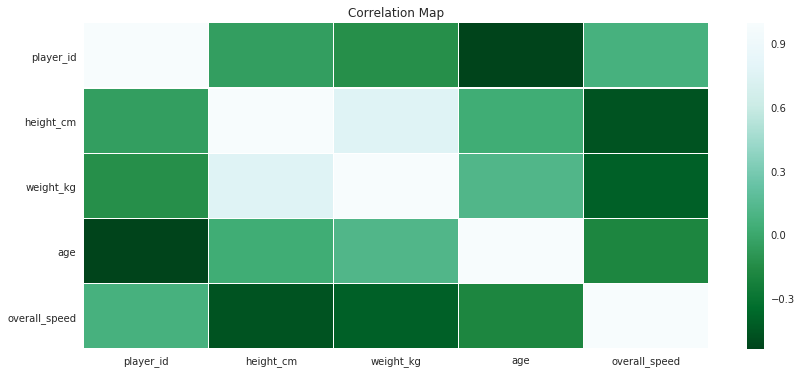

In [17]:
sns.set(rc={'figure.figsize':(14, 6)})
sns.heatmap(df_corr, cmap="BuGn_r", linewidths=0.1).set_title('Correlation Map')

### 2. Evolution of speed by age

The relationship of age and average speed is visible in the graph below. 

From this we can assume that peak age for overall speed is reached at about 24 after followed by a gradual decline.

In [18]:
# It seems that speed increases up to 24 year of age and then begins to decline
df.groupby('age')['overall_speed'].describe()

,count,mean,std,min,25%,50%,75%,max
age,,,,,,,,
18,3235.0,67.185008,10.450017,16.5,62.000,67.5,74.000,95.0
19,4998.0,68.171469,10.595011,16.5,62.500,68.5,75.000,96.0
20,6189.0,68.922685,10.687420,16.5,63.500,70.0,76.000,95.5
21,6891.0,69.691337,10.870300,20.5,64.000,71.0,77.000,96.0
22,7300.0,69.831370,11.095791,16.5,64.500,71.0,77.000,97.0
23,7576.0,70.194694,11.258656,16.0,64.500,71.5,77.500,97.0
24,7588.0,70.277939,11.314462,16.5,64.500,71.5,77.625,97.0
25,7502.0,70.076713,11.512388,16.0,64.500,71.5,78.000,96.5
26,7259.0,69.605386,11.594439,16.0,64.000,71.0,77.500,96.5


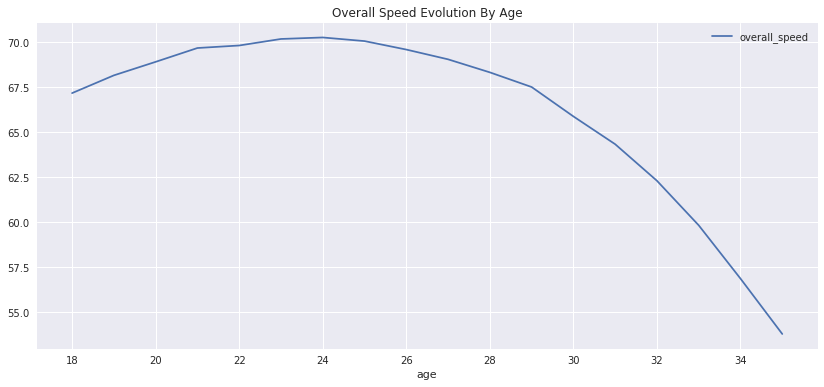

In [19]:
xt = np.arange(18, 35, step=2)
df_groupped_age = df.groupby('age', as_index = False)[['overall_speed']].mean()
df_groupped_age.plot(x = 'age', y = 'overall_speed', kind = "line", title = 'Overall Speed Evolution By Age', xticks = xt)

### 2.1 Speed evolution by age depending on weight and height category
It is important to check whether speed evolution pattern is the same for different weight and height categories.

It seems that the trend is similar for both taller and shorter players.
Comparison of overall speed change by weight categories yields the same result, indicating that speed declines with age regardless of weight or height.

Text(0.5,1,'Overall Speed By Age and Height Category')

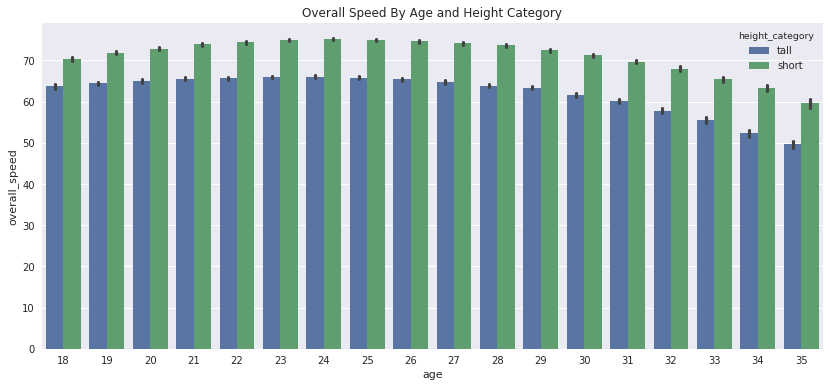

In [24]:
sns.barplot(x = "age", y = 'overall_speed', hue = 'height_category', data = df).set_title("Overall Speed By Age and Height Category")

Text(0.5,1,'Overall Speed By Age and Weight Category')

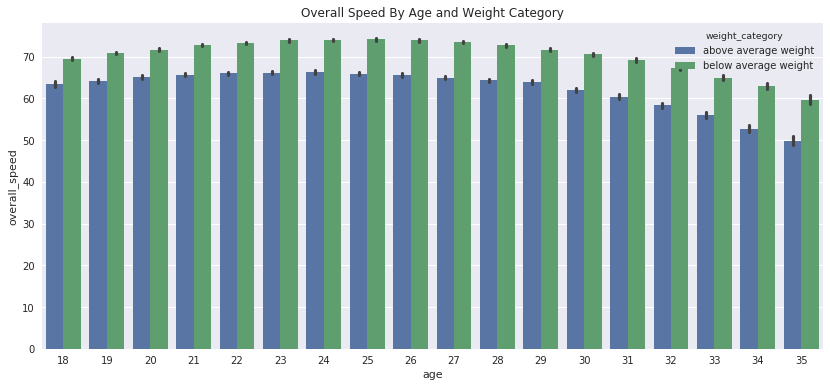

In [20]:
sns.barplot(x = "age", y = 'overall_speed', hue = 'weight_category', data = df).set_title("Overall Speed By Age and Weight Category")

### 3. Investigate relationship between weight and overall speed

First, we investigate the distribution of fast and slow players by weight.

It can be seen that there are significantly more fast players with the weight below 80kg.

On the other hand, there is larger amount of slow players with the weight above 80kg.

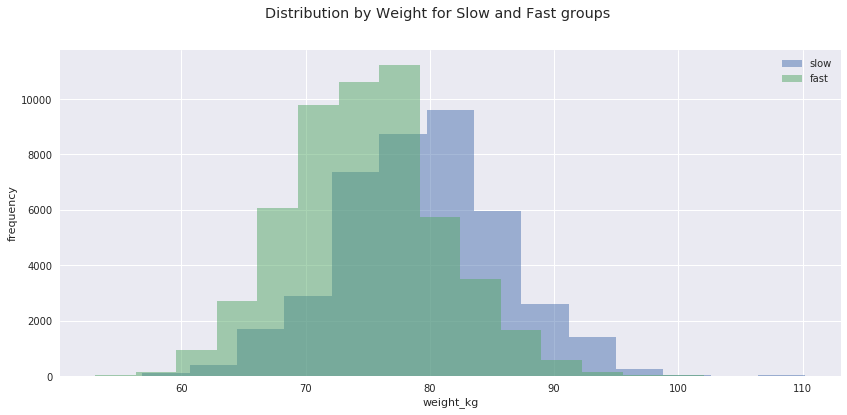

In [36]:
df[df['overall_speed'] <= df['overall_speed'].mean()]['weight_kg'].hist(alpha = 0.5, label = 'slow', bins = 15)
df[df['overall_speed'] > df['overall_speed'].mean()]['weight_kg'].hist(alpha = 0.5, label = 'fast', bins = 15)
plt.suptitle("Distribution by Weight for Slow and Fast groups")
plt.xlabel("weight_kg")
plt.ylabel("frequency")
plt.legend()

The decline of average overall speed associated with weight increase can be seen in the graph below. 

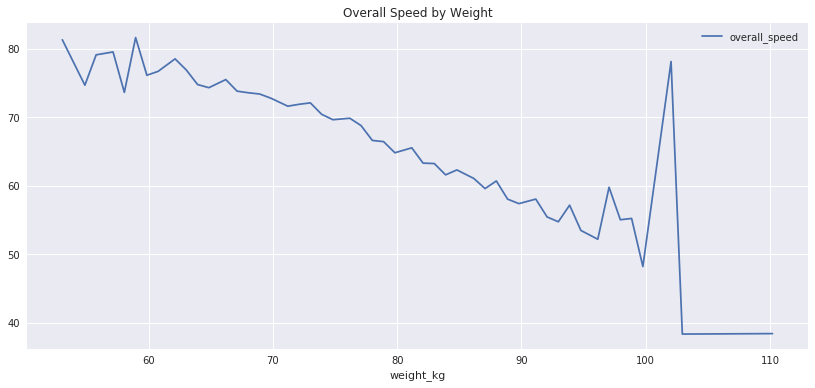

In [22]:
df.groupby(by = 'weight_kg', as_index = False)['overall_speed'].mean().plot(x = 'weight_kg', y = 'overall_speed', kind = 'line', title = "Overall Speed by Weight")

The significance in difference in speed between two weight groups is visible in the plot below. 
The median speed for players with weight below or equal to the mean is higher than upper quartile of the group with the weight above average.

Text(0.5,1,'Boxplot - Overall Speed by Weight Category')

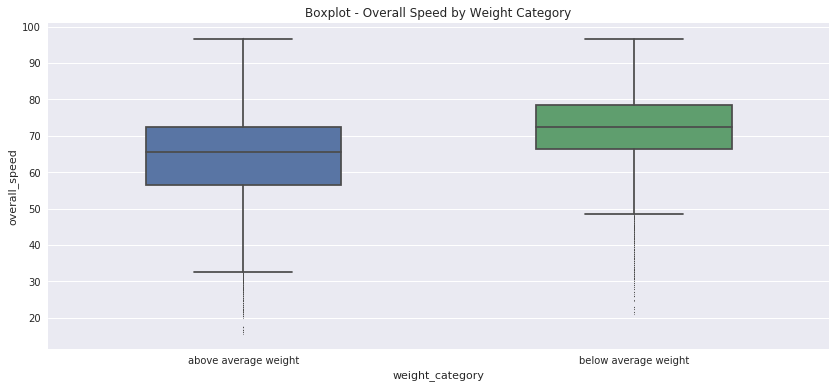

In [23]:
sns.boxplot(x = 'weight_category', y = 'overall_speed', data = df, width = 0.5, fliersize = 1).set_title('Boxplot - Overall Speed by Weight Category')

From the histogram below we can see that there are much more slow players concentrated around the mark of 190cm.
Similarly, there are more fast players with the height below 180cm.

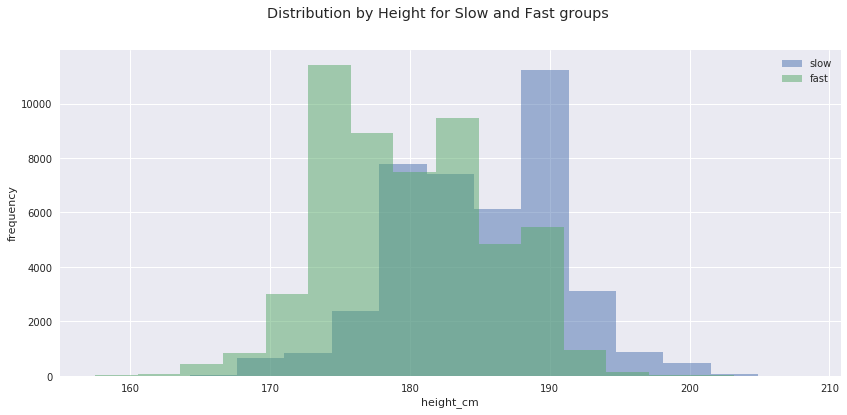

In [35]:
df[df['overall_speed'] <= df['overall_speed'].mean()]['height_cm'].hist(alpha = 0.5, label = 'slow', bins = 15)
df[df['overall_speed'] > df['overall_speed'].mean()]['height_cm'].hist(alpha = 0.5, label = 'fast', bins = 15)
plt.suptitle("Distribution by Height for Slow and Fast groups")
plt.xlabel("height_cm")
plt.ylabel("frequency")
plt.legend()

The dependence of average speed and the height has a downward slope.

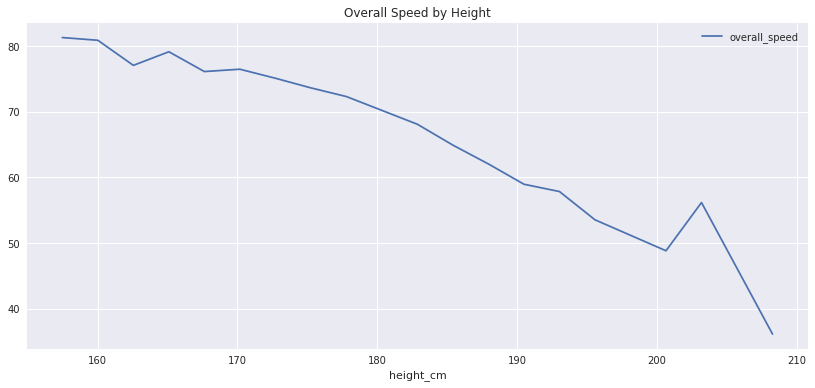

In [25]:
df.groupby(by = 'height_cm', as_index = False)['overall_speed'].mean().plot(x = 'height_cm', y = 'overall_speed', kind = 'line', title = 'Overall Speed by Height')

The difference between two groups is apparent with tall players showing lower average speed

Text(0.5,1,'Overall Speed by Height Category')

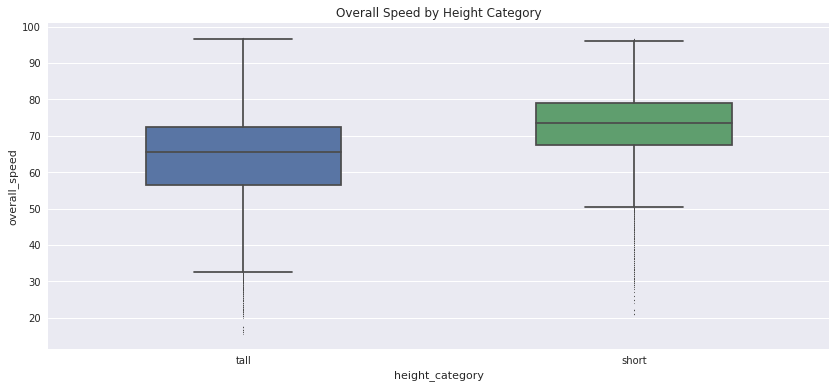

In [26]:
sns.boxplot(x = 'height_category', y = 'overall_speed', data = df, width = 0.5, fliersize = 1).set_title("Overall Speed by Height Category")

The graph below shows average speed for short and tall players detailed by weight category.

Text(0.5,1,'Average Speed by Weight and Height categories')

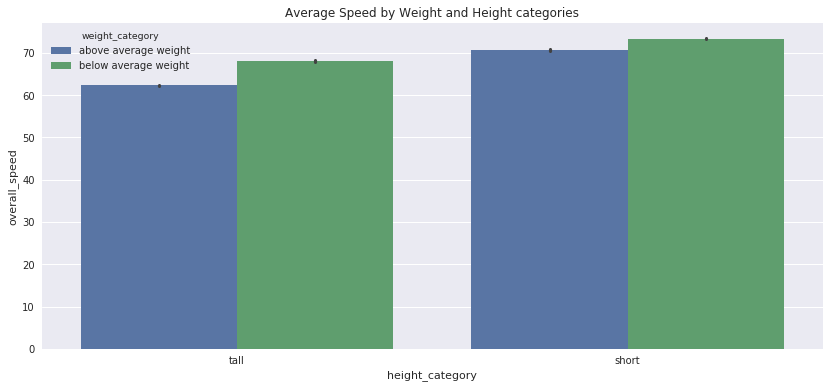

In [27]:
sns.barplot(x = "height_category", y = 'overall_speed', hue = "weight_category", data = df).set_title('Average Speed by Weight and Height categories')

Text(0.5,0.98,'Distribution by Height for Slow and Fast Groups')

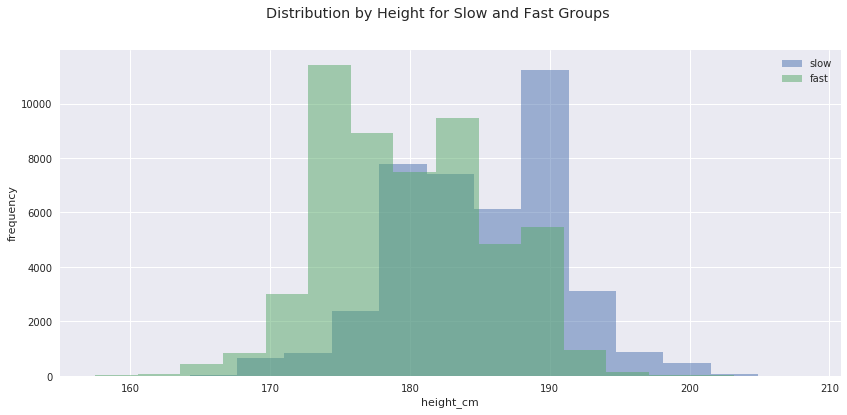

In [32]:
df[df['overall_speed'] <= df['overall_speed'].mean()]['height_cm'].hist(alpha = 0.5, label = 'slow', bins = 15)
df[df['overall_speed'] > df['overall_speed'].mean()]['height_cm'].hist(alpha = 0.5, label = 'fast', bins = 15)
plt.legend()
plt.xlabel("height_cm")
plt.ylabel("frequency")
plt.suptitle("Distribution by Height for Slow and Fast Groups")


Finally, we can see that there is no significant difference in speed between righ and left footed players.

Text(0,0.5,'overall_speed')

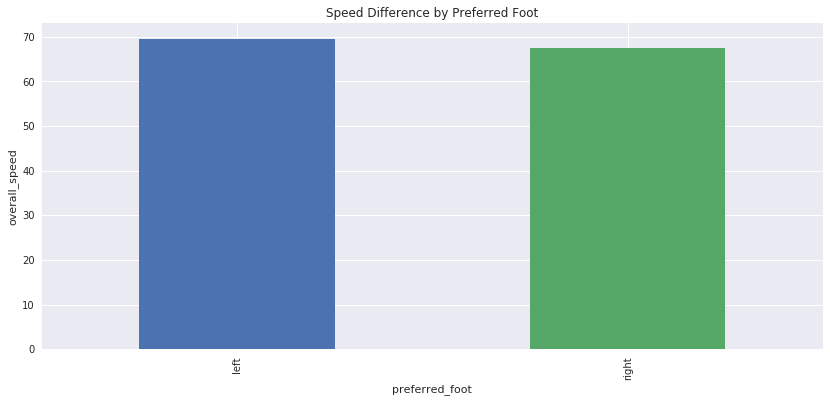

In [34]:
df.groupby('preferred_foot').overall_speed.mean().plot(kind = 'bar', title = 'Speed Difference by Preferred Foot')
plt.ylabel("overall_speed")

<a id='conclusions'></a>
## Conclusions

From the analysis conducted above, we can make following conclusions:
1. Overall Speed for players increases from age 18 to 24, and then starts to decline.
2. The decline of speed after the age of 24 is relevant for all groups of players regardless of weight or height category.
3. Shorter players tend to have higher overall speed, while taller players are at disadvantage on average when it comes to overall speed, especially those above 190cm.
4. Weight has also shown inverse relationship with the speed.
5. Shorter players of both weight categories have higher overall speed than the tall players on average.

It is also important to address limitation imposed on this analysis by dataset content and the scope of research.

1. The dataset provides frequently updated speed ratings, but weight and height are constant for each id, which distorts final conclusion on relationship between speed and those parameters, as speed changes throughout time do not have corresponding physical parameters.

2. The data covers only 11 European leagues, which leaves very limited amount of players consistently present from Y1  to Y10. For example, faster players from outside these 11 leagues may be brought in at the certain age, thus increasing average overall speed for this particular age.

3. The dataset does not contain information regarding players positions, which may be better explanation of speed differences. For example, if players in the positions associated with lower speed requirements, such as GK, tend to have a longer career, the average speed will be brought down towards the upper limits of studied age group.



## Submitting your Project 

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [25]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0